<a id=top></a>

# Uma.Tech

1. [Info](#info)
1. [Load Data and Modules](#load)
1. [Exploratory Data Analysis](#explore)
1. [Derived (engineered) features](#derived)
1. [Modelling](#model)
1. [Creating pipeline](#pipeline)
1. [Submit](#commit)

## Info
<a id=info></a>

**Описание задачи**

Необходимо предсказать отток пользователей условного сервиса.
В данной папке вы найдете набор данных для выполнения задачи:
* TRAIN_PREPARED.csv/TEST_PREPARED.csv - уже предподготовленные данные для решения задачи;
* TRAIN_RAW.csv/TEST_RAW.csv - сырые данные, по которым собирались агрегации для решения задачи;
* TRAIN_ADDITIONAL_DATA.csv/TEST_ADDITIONAL_DATA.csv - дополнительные данные из другого источника.

В ходе решения вам стоит предсказать для email из TEST, уйдут ли они в отток, или останутся и будут
пользоваться данным сервисом.

**Метод предоставления решения задачи:**

Код для решения предлагается оформить в виде IPython Notebook и выложить на GitHub,
поделившись с нами ссылкой в личном кабинете конкурса.
Пример сабмита можно посмотреть в test_submit_example.csv.

### Load Data and Modules
<a id=load></a>

In [1]:
import time
from datetime import timedelta

In [2]:
import pandas as pd
import numpy as np

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import KFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

In [5]:
import itertools
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

In [6]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import FeatureUnion
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline

In [7]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer

In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

In [9]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

plt.style.use('seaborn-white')
sns.set(rc={'figure.figsize': (9,6)})

pd.options.display.float_format = '{:.2f}'.format

In [10]:
def time_format(sec):
    return str(timedelta(seconds=sec))

In [11]:
TARGET='label'
RANDOM_STATE=42
DATE_FORMAT = '%Y-%m-%d %H:%M:%S'

### Load data

In [12]:
train_prepared = pd.read_csv('datasets/TRAIN_PREPARED.csv', index_col='email')
train_additional_data = pd.read_csv('datasets/TRAIN_ADDITIONAL_DATA.csv', index_col='email')
train_raw_data = pd.read_csv('datasets/TRAIN_RAW_DATA.csv', index_col='email')

In [13]:
train_prepared.head()

,cut_date,days_to_end,first_date,last_date,num_country_max_1days,num_city_max_1days,android_max_1days,smarttv_max_1days,iphone_max_1days,ipad_max_1days,...,apple_max_30days,pc_max_30days,activity_1to3,activity_1to7,activity_1to14,activity_7to14,activity_7to21,activity_7to30,activity_14to30,label
email,,,,,,,,,,,,,,,,,,,,,
8ba752f2c5,2019-04-02 00:00:00,11,2019-02-10 00:00:00,2019-03-13 09:36:59,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
752a6d96f7,2019-04-02 00:00:00,10,2018-10-28 00:00:00,2019-04-01 20:51:29,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,4.00,0.00,0.00,0.00,0.01,0.01,0.00,0.52,1.00
827f6afef3,2019-04-02 00:00:00,4,2018-12-14 00:00:00,2019-04-01 18:00:49,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,6.00,0.00,0.00,0.00,0.94,0.83,0.60,0.64,0.00
346e0f766c,2019-04-02 00:00:00,9,2019-03-08 00:00:00,2019-03-31 23:05:17,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,6.00,0.00,0.00,0.00,0.54,0.54,0.32,0.59,1.00
0addbcc79a,2019-04-02 00:00:00,10,2019-01-09 00:00:00,2019-03-25 17:41:09,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,6.00,0.00,0.00,0.00,0.00,0.00,0.00,0.42,0.00


In [14]:
train_additional_data.head()

,action,trial,calday
email,,,
9007366702,DELETE,NaN,2018-10-26 03:26:41.607
ad49ae7b1d,CREATE,False,2018-12-01 18:16:56.971
2165677f19,CREATE,False,2018-12-01 18:16:58.380
13ded413c2,CREATE,False,2018-12-01 18:16:58.444
032adbb404,CREATE,False,2018-12-01 18:16:59.568


In [15]:
train_raw_data.head()

,title_ep,title_ru,calday,dt1,timelength,device,country_iso_code,city_iso_code,utc_offset
email,,,,,,,,,
513ed17481,1821f1a1ce58,f1bcc7a5177e,2019-03-04 00:00:00,2019-03-04 17:14:48,45,PC,RU,MOW,3.00
0160e02b90,c724f041dc39,a714d9f17666,2019-03-04 00:00:00,2019-03-04 23:23:19,60,AndroidPhone_PlayReady_HW,RU,MOW,3.00
0160e02b90,50409694c8a8,5e8ec479ee7e,2019-03-04 00:00:00,2019-03-04 21:06:59,1273,AndroidPhone_PlayReady_HW,RU,MOW,3.00
8a92686302,c724f041dc39,a714d9f17666,2019-03-04 00:00:00,2019-03-04 23:46:01,60,PC,RU,MOW,3.00
8a92686302,c724f041dc39,a714d9f17666,2019-03-04 00:00:00,2019-03-04 23:46:05,60,PC,RU,MOW,3.00


[Go to the top of the page](#top)

## Exploratory Data Analysis
<a id=explore></a>

#### Target Variable Distribution

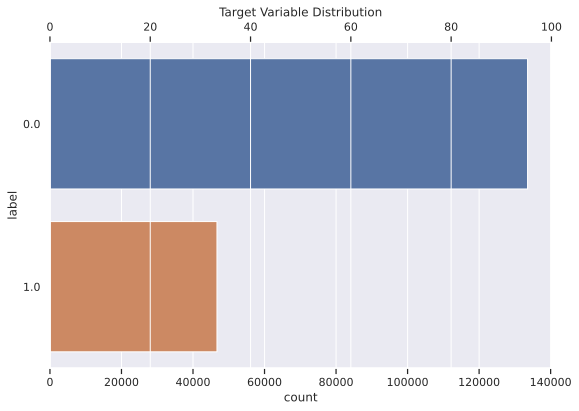

In [16]:
plt.title('Target Variable Distribution')
sns.countplot(y=TARGET, data=train_prepared).twiny().set_xlim([0,100]);

### Checking the uniqueness of records

In [17]:
train_prepared.index.is_unique

False

In [18]:
train_additional_data.index.is_unique

False

In [19]:
train_raw_data.index.is_unique

False

## Derived (engineered) features
<a id=derived></a>

In [20]:
def add_features(X, additional_data, raw_data, silent=False):
        
    if not silent:
        start_t = time.time()
        print('Start adding features'.center(100,'*'))
    assert isinstance(X, pd.DataFrame), 'This is not a pandas dataframe'
    
    last_action = additional_data.sort_values('calday', ascending=False) \
                                .groupby('email') \
                                .first()[['action']] \
                                .reset_index() \
                                .drop_duplicates()
    
    create_action_count = additional_data[additional_data['action'] == 'CREATE'] \
                                .groupby('email')[['action']] \
                                .count() \
                                .rename(columns={'action': 'create_action_count'})
    
    delete_action_count = additional_data[additional_data['action'] == 'DELETE'] \
                                .groupby('email')[['action']] \
                                .count() \
                                .rename(columns={'action': 'delete_action_count'})
    
    device_count = raw_data.groupby('email')[['device']] \
                                .nunique() \
                                .rename(columns={'device': 'device_count'})
    
    country_iso_code = raw_data.groupby('email')[['country_iso_code']].last()
    
    city_iso_code = raw_data.groupby('email')[['country_iso_code']].last()
    
    timelength = raw_data.groupby('email')[['timelength']].sum()
                 
    features_list = [
            last_action, create_action_count, delete_action_count, 
            device_count, city_iso_code, timelength
    ]
    X_merge = X.copy()
    
    X_merge['count_days'] = (pd.to_datetime(X['last_date'], format=DATE_FORMAT).dt.date \
                    - pd.to_datetime(X['first_date'], format=DATE_FORMAT).dt.date).dt.days
    
    for features in features_list:
        X_merge = X_merge.reset_index() \
                        .merge(features.reset_index(), on=X.index.name, how='left', suffixes=('_train', '_features')) \
                        .set_index(X.index.name)
      
    assert X_merge.shape[0] == X.shape[0], f'Shapes of dataframe don\'t match: {X_merge.shape[0]} and {X.shape[0]}'
    assert (X_merge.index == X.index).all(), 'Index Sort Error'
    if not silent:
        print(f'End adding features, run time: {time_format(time.time()-start_t)}'.center(100,'*'))
        print()
    return X_merge

In [21]:
train = add_features(train_prepared, additional_data=train_additional_data, raw_data=train_raw_data)

***************************************Start adding features****************************************
***************************End adding features, run time: 0:00:03.485538****************************



### Examine Missing Values

In [22]:
print(f'Missing values in train data: {train_prepared.isnull().sum().sum() / train_prepared.count().sum() * 100:.02f} % of total Values')

Missing values in train data: 0.00 % of total Values


In [23]:
print(f'Missing values in features data: {train_additional_data.isnull().sum().sum() / train_additional_data.count().sum() * 100:.02f} % of total Values')

Missing values in features data: 0.15 % of total Values


In [24]:
print(f'Missing values in features data: {train_raw_data.isnull().sum().sum() / train_raw_data.count().sum() * 100:.02f} % of total Values')

Missing values in features data: 0.23 % of total Values


[Go to the top of the page](#top)

### Splitting the train sample

In [25]:
X = train.drop(columns=TARGET)
y = train[TARGET]

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.30, random_state=RANDOM_STATE)

### Features type determination

In [26]:
df_nunique = X_train.apply(lambda x: x.nunique(dropna=False))

In [27]:
f_all = set(df_nunique.index.tolist())
len(f_all)

152

#### Dates

In [28]:
f_date = set(col for col in train.columns if 'date' in col)

len(f_date)

3

In [29]:
f_other = f_all - f_date

len(f_other)

149

#### Constant features

In [30]:
f_const = set(df_nunique[df_nunique == 1].index.tolist())

len(f_const)

0

In [31]:
f_other = f_other - f_const

len(f_other)

149

#### Binary features

In [32]:
f_binary = set(X_train.loc[:, f_other].columns[(
                      (X_train.loc[:, f_other].max() == 1) & \
                      (X_train.loc[:, f_other].min() == 0) & \
                      (X_train.loc[:, f_other].isnull().sum() == 0))])
len(f_binary)

0

In [33]:
f_other = f_other - f_binary
len(f_other)

149

#### Categorical features

In [34]:
f_categorical = set(train[f_other].select_dtypes('object').columns)
len(f_categorical)

2

In [35]:
f_other = f_other - f_categorical
len(f_other)

147

#### Numeric features

In [36]:
f_numeric = f_other
len(f_numeric)

147

In [37]:
assert(X_train.shape[1] == len(f_date) + len(f_const) + len(f_binary) + len(f_numeric) + len(f_categorical))

In [38]:
print(f'f_all: {X_train.shape[1]}\n')
print(f'f_date: {len(f_date)}')
print(f'f_const: {len(f_const)}')
print(f'f_binary: {len(f_binary)}')
print(f'f_categorical: {len(f_categorical)}')
print(f'f_numeric: {len(f_numeric)}')

f_ok = f_all

f_date = list(f_date)
f_binary = list(f_binary)
f_categorical = list(f_categorical)
f_numeric = list(f_numeric)

f_all: 152

f_date: 3
f_const: 0
f_binary: 0
f_categorical: 2
f_numeric: 147


### Pipeline processing features

In [39]:
class MemUseOptimizing(BaseEstimator, TransformerMixin):
    def __init__(self, silent=True):
        self.silent = silent

    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        start_t = time.time()
        
        assert isinstance(X, pd.DataFrame), 'This is not a pandas dataframe'
    
        if not self.silent:
            print('Start of dataframe memory use optimizing'.center(100,'*'))
            start_memory_usage = X.memory_usage(deep=True).sum() / 1024**2 
            
        
            X_dtype = pd.DataFrame(X.dtypes, columns=['dtype'], index = X.columns)                
            
            X_dtype['min'] = X.select_dtypes(['int', 'float']).min()
            X_dtype['max'] = X.select_dtypes(['int', 'float']).max()
            X_dtype['is_int'] = ~(X.select_dtypes(['int', 'float']).astype(int).sum() - X.select_dtypes(['int', 'float']).sum()).astype('bool_')
            
            X_dtype.loc[(X_dtype['is_int'] == True),'dtype'] = 'int64'
            X_dtype.loc[(X_dtype['is_int'] == True) & (X_dtype['min'] >= np.iinfo('int32').min) & (X_dtype['max'] <= np.iinfo('int32').max),'dtype'] = 'int32'
            X_dtype.loc[(X_dtype['is_int'] == True) & (X_dtype['min'] >= np.iinfo('int16').min) & (X_dtype['max'] <= np.iinfo('int16').max),'dtype'] = 'int16'
            X_dtype.loc[(X_dtype['is_int'] == True) & (X_dtype['min'] >= np.iinfo('int8').min) & (X_dtype['max'] <= np.iinfo('int8').max),'dtype'] = 'int8'
            
            X_dtype.loc[(X_dtype['is_int'] == True) & (X_dtype['min'] >= np.iinfo('uint64').min) ,'dtype'] = 'uint64'
            X_dtype.loc[(X_dtype['is_int'] == True) & (X_dtype['min'] >= np.iinfo('uint32').min) & (X_dtype['max'] <= np.iinfo('uint32').max),'dtype'] = 'uint32'
            X_dtype.loc[(X_dtype['is_int'] == True) & (X_dtype['min'] >= np.iinfo('uint16').min) & (X_dtype['max'] <= np.iinfo('uint16').max),'dtype'] = 'uint16'
            X_dtype.loc[(X_dtype['is_int'] == True) & (X_dtype['min'] >= np.iinfo('uint8').min) & (X_dtype['max'] <= np.iinfo('uint8').max),'dtype'] = 'uint8'
            
            X_dtype.loc[(X_dtype['is_int'] == True) & (X_dtype['min'] == 0) & (X_dtype['max'] == 1),'dtype'] = 'bool_'
            
            X_dtype.loc[(X_dtype['is_int'] == False), 'dtype'] = 'float64'
            X_dtype.loc[(X_dtype['is_int'] == False) & (X_dtype['min'] >= np.finfo('float32').min) & (X_dtype['max'] <= np.finfo('float32').max), 'dtype'] = 'float32'
            X_dtype.loc[(X_dtype['is_int'] == False) & (X_dtype['min'] >= np.finfo('float16').min) & (X_dtype['max'] <= np.finfo('float16').max), 'dtype'] = 'float16'
            
            for col in X.select_dtypes('object').columns:
                num_unique_values = len(X[col].unique())
                num_total_values = len(X[col])
                if num_unique_values / num_total_values < 0.5:
                    X_dtype.loc[col, 'dtype'] = 'category'
                    
            dtype = X_dtype['dtype'].to_dict()
                   
            X = X.astype(dtype)
            
        if not self.silent:
            memory_usage = X.memory_usage(deep=True).sum() / 1024**2
            print('Memory use optimizing'.center(100,'*'))
            print(f'Memory usage of properties dataframe before optimizing: {start_memory_usage:.02f} MB')
            print(f'Memory usage of properties dataframe after optimizing: {memory_usage:.02f} MB')      
            print(f'This is {100*memory_usage/start_memory_usage:.02f} % of the initial size')
            print(f'End of dataframe memory use optimizing, run time: {time_format(time.time()-start_t)}'.center(64,'*'))
            print()
                
        return X

In [40]:
class GetDate(BaseEstimator, TransformerMixin):
    def __init__(self, silent=True):
        self.silent = silent
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        if not self.silent:
            start_t = time.time()
            print('Start geting date from timestamp'.center(100,'*'))
        if isinstance(X, pd.Series):
            X = pd.DataFrame(X)

        assert isinstance(X, pd.DataFrame), 'This is not a pandas dataframe or series'
        
        df = pd.DataFrame()
        
        for col in X.columns:
            df[f'{col}_day'] = pd.to_datetime(X[col], format=DATE_FORMAT).dt.day
            df[f'{col}_month'] = pd.to_datetime(X[col], format=DATE_FORMAT).dt.month
            df[f'{col}_year'] = pd.to_datetime(X[col], format=DATE_FORMAT).dt.year              
            df[f'{col}_week'] = pd.to_datetime(X[col], format=DATE_FORMAT).dt.week
            df[f'{col}_weekofyear'] = pd.to_datetime(X[col], format=DATE_FORMAT).dt.weekofyear
            df[f'{col}_weekday'] = pd.to_datetime(X[col], format=DATE_FORMAT).dt.weekday
            
        if not self.silent:
            print(f'End geting date from timestamp, run time: {time_format(time.time()-start_t)}'.center(100,'*'))
            print()
        return df

In [41]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self
      
    def transform(self, X):
        assert isinstance(X, pd.DataFrame)

        try:
            return X[self.columns]
        except KeyError:
            cols_error = list(set(self.columns) - set(X.columns))
            raise KeyError(f'DataFrame does not contain the following columns: {cols_error}')

In [42]:
f_prep_pipeline = make_pipeline(
    ColumnSelector(columns=f_ok),
    MemUseOptimizing(),
    FeatureUnion(transformer_list=[
                        ('date_features', make_pipeline(
                            ColumnSelector(f_date),
                            GetDate(),
                            StandardScaler()
                        )),
                        ('numeric_features', make_pipeline(
                            ColumnSelector(f_numeric),
                            SimpleImputer(strategy='mean'),
                            StandardScaler(),
                        )),
                        ('categorical_features', make_pipeline(
                            ColumnSelector(f_categorical),
                            SimpleImputer(strategy='most_frequent'),
                            OneHotEncoder(handle_unknown='ignore', sparse=False)
                        )),
                        ('boolean_features', make_pipeline(
                            ColumnSelector(f_binary),
                        ))
    ])
)

In [43]:
n_features = f_prep_pipeline.fit_transform(X_train).shape
n_features[1]

232

[Go to the top of the page](#top)

## Modelling
<a id=model></a>

In [44]:
def get_classification_report(models_list, X_train, y_train, 
                                        X_test, y_test, 
                                        classes,
                                        title='',
                                        threshold=0.5):
    
    for model_name, model in models_list.items():
        print()
        y_train_pred = model.predict_proba(X_train)[:,1]
        y_test_pred = model.predict_proba(X_test)[:,1]
        
        y_train_pred = y_train_pred > threshold
        y_test_pred = y_test_pred > threshold
        
        print(f'{model_name}. {title}'.center(53, '*'))
        print('TRAIN\n\n' + classification_report(y_train, y_train_pred))
        print('TEST\n\n' + classification_report(y_test, y_test_pred))
        plt.figure(figsize=(7, 4))
        plot_confusion_matrix(y_test, y_test_pred, classes=classes, title=f'Confusion matrix.\n {model_name}. {title}')
        plt.show()
        print('_'*53)
        print('\n')

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    
    cm = confusion_matrix(y_true, y_pred)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.grid(False)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes, rotation=90)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment='center', fontsize=16,
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
def plot_roc_pr(models_list, X_train, y_train, X_test, y_test, title='', threshold=0.5):

    f, (ax1, ax2) = plt.subplots(2, 1, sharey=True)
    
    f.set_figheight(10)
    f.set_figwidth(20)
    
    ax1 = plt.subplot(121)
    ax1.set_title(f'ROC. {title}')
    ax1.set_xlabel('TPR')
    ax1.set_ylabel('FPR')
    ax1.set_aspect('equal')
    ax1.plot([0, 1], [0, 1], 'k--')
    
    ax2 = plt.subplot(122)
    ax2.set_title(f'PR. {title}')
    ax2.set_xlabel('Recall')
    ax2.set_ylabel('Precision')
    ax2.set_aspect('equal')
    
    f_scores = np.linspace(0.2, 0.8, num=4)
    for f_score in f_scores:
        x = np.linspace(0.01, 1)
        y = f_score * x / (2 * x - f_score)
        l, = plt.plot(x[y >= 0], y[y >= 0], color='gray', alpha=0.2)
        ax2.annotate(f'f1={f_score:0.1f}', xy=(0.9, y[45] + 0.02), fontsize=14)
        
    ax2.set_xlim([0.0, 1.0])
    ax2.set_ylim([0.0, 1.05])
    
    for model_name, model in models_list.items():
        y_pred_proba = model.predict_proba(X_test)[:,1]
        y_pred = y_pred_proba > threshold
        
        fpr, tpr, roc_thresholds = roc_curve(y_test, y_pred_proba)
        precision, recall, pr_thresholds = precision_recall_curve(y_test, y_pred_proba)
        
        ax1.plot(fpr, tpr, label=f'{model_name} (ROC AUC={roc_auc_score(y_test, y_pred):.2f})')       
        ax2.plot(recall, precision, label=f'{model_name} (f1={f1_score(y_test, y_pred):.2f})')

    ax1.legend(loc="lower right")
    ax2.legend(loc="lower left")
    
    plt.show()
    
def show_proba_calibration_plots(y_predicted_probs, y_true_labels):
    preds_with_true_labels = np.array(list(zip(y_predicted_probs, y_true_labels)))

    thresholds = []
    precisions = []
    recalls = []
    roc_auc = []

    for threshold in np.linspace(0.1, 0.9, 9):
        thresholds.append(threshold)
        precisions.append(precision_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        recalls.append(recall_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        roc_auc.append(roc_auc_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))

    scores_table = pd.DataFrame({'roc_auc':roc_auc,
                                 'precision':precisions,
                                 'recall':recalls,
                                 'probability':thresholds}).sort_values('roc_auc', ascending=False).round(3)
  
    figure = plt.figure(figsize = (15, 5))

    plt1 = figure.add_subplot(121)
    plt1.plot(thresholds, precisions, label='Precision', linewidth=4)
    plt1.plot(thresholds, recalls, label='Recall', linewidth=4)
    plt1.plot(thresholds, roc_auc, label='ROC AUC', linewidth=4)
    plt1.set_ylabel('Scores')
    plt1.set_xlabel('Probability threshold')
    plt1.set_title('Probabilities threshold calibration')
    plt1.legend(bbox_to_anchor=(1, 1))   
    plt1.table(cellText = scores_table.values,
               colLabels = scores_table.columns, 
               colLoc = 'center', cellLoc = 'center', loc = 'bottom', bbox = [0, -1.3, 1, 1])

    plt2 = figure.add_subplot(122)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 0][:, 0], 
              label='Another class', color='royalblue', alpha=1)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 1][:, 0], 
              label='Main class', color='darkcyan', alpha=0.8)
    plt2.set_ylabel('Number of examples')
    plt2.set_xlabel('Probabilities')
    plt2.set_title('Probability histogram')
    plt2.legend(bbox_to_anchor=(1, 1))
    
    plt.show()

### Baseline models

In [45]:
lg_bl_pipe = make_pipeline(
                    f_prep_pipeline,
                    LogisticRegression(random_state=RANDOM_STATE, n_jobs=-1)
)

rf_bl_pipe = make_pipeline(
                    f_prep_pipeline,
                    RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=-1)
)


xgb_bl_pipe = make_pipeline(
                    f_prep_pipeline,
                    XGBClassifier(random_state=RANDOM_STATE, n_jobs=-1)
)


lgbm_bl_pipe = make_pipeline(
                    f_prep_pipeline,
                    LGBMClassifier(random_state=RANDOM_STATE),
)


cat_bl_pipe = make_pipeline(
                    f_prep_pipeline,
                    CatBoostClassifier(random_state=RANDOM_STATE, logging_level='Silent'),
)

In [46]:
models_list = {
    'Logistic Regression': lg_bl_pipe,
    'Random Forest Classifier': rf_bl_pipe,
    'XGBoost': xgb_bl_pipe,
    'LightGBM': lgbm_bl_pipe, 
    'CatBoost': cat_bl_pipe
}

#### Fit models

In [47]:
for model_name, model in models_list.items():
    start_t = time.time()
    print(f'Start fit {model_name}'.center(100,'*'))
    model.fit(X_train, y_train)
    print(f'End fit {model_name}, run time: {time_format(time.time()-start_t)}'.center(100,'*'))
    print()

***********************************Start fit Logistic Regression************************************
***********************End fit Logistic Regression, run time: 0:00:50.305220************************

*********************************Start fit Random Forest Classifier*********************************
*********************End fit Random Forest Classifier, run time: 0:00:11.114773*********************

*****************************************Start fit XGBoost******************************************
*****************************End fit XGBoost, run time: 0:01:25.167035******************************

*****************************************Start fit LightGBM*****************************************
*****************************End fit LightGBM, run time: 0:00:13.736399*****************************

*****************************************Start fit CatBoost*****************************************
*****************************End fit CatBoost, run time: 0:00:26.612223****************


************Logistic Regression. Baseline************
TRAIN

              precision    recall  f1-score   support

         0.0       0.86      0.95      0.90     93501
         1.0       0.79      0.58      0.67     32673

    accuracy                           0.85    126174
   macro avg       0.83      0.76      0.79    126174
weighted avg       0.85      0.85      0.84    126174

TEST

              precision    recall  f1-score   support

         0.0       0.86      0.95      0.90     40047
         1.0       0.80      0.57      0.66     14028

    accuracy                           0.85     54075
   macro avg       0.83      0.76      0.78     54075
weighted avg       0.85      0.85      0.84     54075



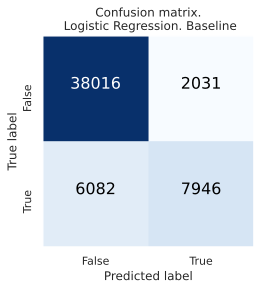

_____________________________________________________



**********Random Forest Classifier. Baseline*********
TRAIN

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     93501
         1.0       1.00      1.00      1.00     32673

    accuracy                           1.00    126174
   macro avg       1.00      1.00      1.00    126174
weighted avg       1.00      1.00      1.00    126174

TEST

              precision    recall  f1-score   support

         0.0       0.96      1.00      0.98     40047
         1.0       0.99      0.89      0.94     14028

    accuracy                           0.97     54075
   macro avg       0.98      0.94      0.96     54075
weighted avg       0.97      0.97      0.97     54075



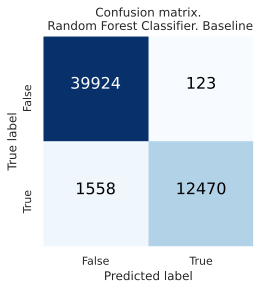

_____________________________________________________



******************XGBoost. Baseline******************
TRAIN

              precision    recall  f1-score   support

         0.0       0.94      0.99      0.96     93501
         1.0       0.96      0.83      0.89     32673

    accuracy                           0.95    126174
   macro avg       0.95      0.91      0.93    126174
weighted avg       0.95      0.95      0.94    126174

TEST

              precision    recall  f1-score   support

         0.0       0.93      0.98      0.95     40047
         1.0       0.94      0.78      0.85     14028

    accuracy                           0.93     54075
   macro avg       0.93      0.88      0.90     54075
weighted avg       0.93      0.93      0.93     54075



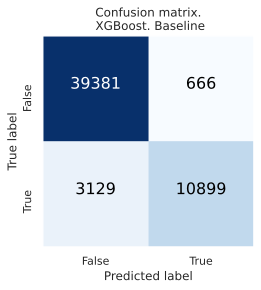

_____________________________________________________



******************LightGBM. Baseline*****************
TRAIN

              precision    recall  f1-score   support

         0.0       0.89      0.97      0.93     93501
         1.0       0.87      0.67      0.76     32673

    accuracy                           0.89    126174
   macro avg       0.88      0.82      0.84    126174
weighted avg       0.89      0.89      0.88    126174

TEST

              precision    recall  f1-score   support

         0.0       0.89      0.96      0.92     40047
         1.0       0.86      0.64      0.74     14028

    accuracy                           0.88     54075
   macro avg       0.87      0.80      0.83     54075
weighted avg       0.88      0.88      0.87     54075



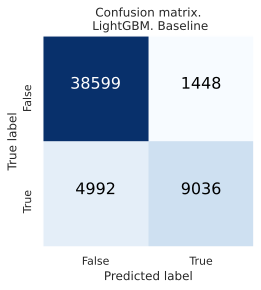

_____________________________________________________



******************CatBoost. Baseline*****************
TRAIN

              precision    recall  f1-score   support

         0.0       0.94      0.99      0.96     93501
         1.0       0.95      0.82      0.88     32673

    accuracy                           0.94    126174
   macro avg       0.95      0.90      0.92    126174
weighted avg       0.94      0.94      0.94    126174

TEST

              precision    recall  f1-score   support

         0.0       0.92      0.98      0.95     40047
         1.0       0.94      0.77      0.85     14028

    accuracy                           0.93     54075
   macro avg       0.93      0.88      0.90     54075
weighted avg       0.93      0.93      0.92     54075



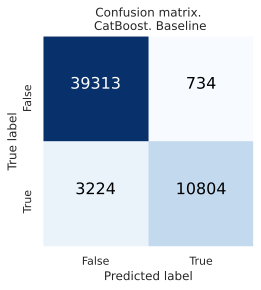

_____________________________________________________




In [48]:
get_classification_report(
                        models_list, \
                        X_train, y_train, X_test, y_test, \
                        classes=['False', 'True'], \
                        title='Baseline'
                             )

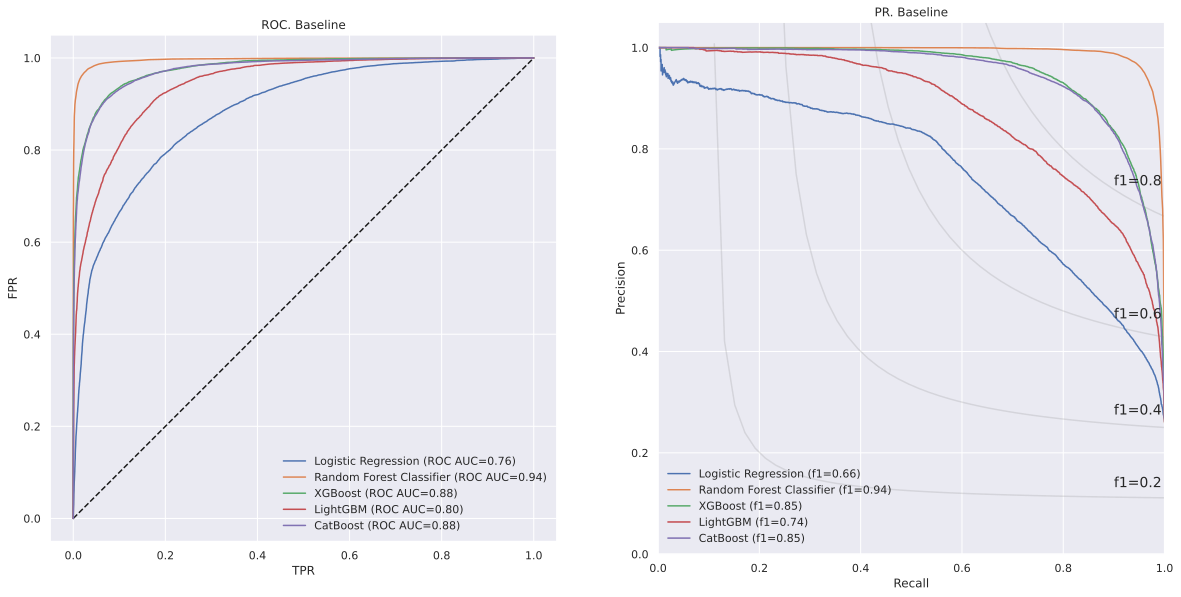

In [49]:
plot_roc_pr(models_list, X_train, y_train, X_test, y_test, title='Baseline')

### Feature Selection

In [48]:
fs_pipe = make_pipeline(
                    f_prep_pipeline,
                    SelectFromModel(RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=-1), threshold=1e-5), 
)

In [49]:
f_prep_pipeline.fit(X_train)
f_prep_pipeline.transform(X_test).shape

(54075, 232)

In [50]:
fs_pipe.fit(X_train, y_train)
fs_pipe.transform(X_test).shape

(54075, 195)

### Randomized Search

In [58]:
rf_fs_pipe = make_pipeline(
                    f_prep_pipeline,
                    SelectFromModel(RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=-1), threshold=1e-5),
                    RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=-1)
)


xgb_fs_pipe = make_pipeline(
                    f_prep_pipeline,
                    SelectFromModel(RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=-1), threshold=1e-5),
                    XGBClassifier(random_state=RANDOM_STATE, n_jobs=-1)
)

In [52]:
cv=KFold(n_splits=3, random_state=RANDOM_STATE, shuffle=True)

In [53]:
param_grid = {
                'selectfrommodel__threshold': [-np.inf, 1e-05],
                'randomforestclassifier__n_estimators': np.arange(100, 1000, 100),
                'randomforestclassifier__min_samples_split': np.arange(0, 1, 0.1),
                'randomforestclassifier__class_weight': ['balanced', 'balanced_subsample',  None],
                'randomforestclassifier__max_depth': np.arange(1, 10, 1),
}

In [54]:
cv=KFold(n_splits=3, random_state=RANDOM_STATE, shuffle=True)
grid = RandomizedSearchCV(rf_fs_pipe, param_grid, scoring='roc_auc', cv=cv, n_jobs=-1)
grid.fit(X_train, y_train);

In [55]:
print(f'Best ROC AUC: {grid.best_score_:.2f}')

print()
print(f'Best parameters set found on development set:')
print()
print(grid.best_params_)

print()
print('Grid scores on development set:')
print()

for i, params in enumerate(grid.cv_results_['params']):
    print(f'{grid.cv_results_["mean_test_score"][i]:0.3f} (+/-{grid.cv_results_["std_test_score"][i] * 2:0.03f})')

print()

Best ROC AUC: 0.83

Best parameters set found on development set:

{'selectfrommodel__threshold': -inf, 'randomforestclassifier__n_estimators': 300, 'randomforestclassifier__min_samples_split': 0.2, 'randomforestclassifier__max_depth': 5, 'randomforestclassifier__class_weight': 'balanced'}

Grid scores on development set:

0.500 (+/-0.000)
0.833 (+/-0.014)
0.769 (+/-0.022)
0.500 (+/-0.000)
0.766 (+/-0.008)
0.796 (+/-0.017)
0.769 (+/-0.008)
0.500 (+/-0.000)
0.753 (+/-0.005)
0.753 (+/-0.004)



In [59]:
param_grid = {
                'selectfrommodel__threshold': [-np.inf, 1e-05],
                'xgbclassifier__learning_rate': np.arange(0.01, 1.0, 0.05),
                'xgbclassifier__n_estimators': np.arange(200, 800, 50),
                'xgbclassifier__max_depth': np.arange(3, 10, 1),
                'xgbclassifier__min_child_weight': np.arange(5, 15, 1),
                'xgbclassifier__subsample': np.arange(0.7, 1.5, 1),
                'xgbclassifier__colsample_bytree': np.arange(0.5, 1.0, 0.1),
                'xgbclassifier__gamma': np.arange(0, 5, 1),
                'xgbclassifier__reg_alpha': np.arange(0.01, 0.1, 0.01)
}

In [61]:
cv=KFold(n_splits=3, random_state=RANDOM_STATE, shuffle=True)
grid = RandomizedSearchCV(xgb_fs_pipe, param_grid, scoring='roc_auc', cv=cv, n_jobs=-1)
grid.fit(X_train, y_train);

In [62]:
print(f'Best ROC AUC: {grid.best_score_:.2f}')

print()
print(f'Best parameters set found on development set:')
print()
print(grid.best_params_)

print()
print('Grid scores on development set:')
print()

for i, params in enumerate(grid.cv_results_['params']):
    print(f'{grid.cv_results_["mean_test_score"][i]:0.3f} (+/-{grid.cv_results_["std_test_score"][i] * 2:0.03f})')

print()

Best ROC AUC: 0.99

Best parameters set found on development set:

{'xgbclassifier__subsample': 0.7, 'xgbclassifier__reg_alpha': 0.060000000000000005, 'xgbclassifier__n_estimators': 450, 'xgbclassifier__min_child_weight': 14, 'xgbclassifier__max_depth': 9, 'xgbclassifier__learning_rate': 0.16000000000000003, 'xgbclassifier__gamma': 0, 'xgbclassifier__colsample_bytree': 0.7999999999999999, 'selectfrommodel__threshold': 1e-05}

Grid scores on development set:

0.990 (+/-0.002)
0.962 (+/-0.004)
0.964 (+/-0.004)
0.992 (+/-0.002)
0.970 (+/-0.001)
0.989 (+/-0.001)
0.965 (+/-0.003)
0.972 (+/-0.001)
0.987 (+/-0.002)
0.947 (+/-0.004)



In [45]:
xgb_pipe_param = {
        'xgbclassifier__subsample': 0.7, 
        'xgbclassifier__reg_alpha': 0.06, 
        'xgbclassifier__n_estimators': 450, 
        'xgbclassifier__min_child_weight': 14, 
        'xgbclassifier__max_depth': 9, 
        'xgbclassifier__learning_rate': 0.16, 
        'xgbclassifier__gamma': 0, 
        'xgbclassifier__colsample_bytree': 0.80, 
        'selectfrommodel__threshold': 1e-05
}

In [46]:
final_pipe = make_pipeline(
                    f_prep_pipeline,
                    SelectFromModel(RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=-1), threshold=1e-5),
                    XGBClassifier(random_state=RANDOM_STATE, n_jobs=-1)
)

In [47]:
final_pipe.set_params(**xgb_pipe_param);

In [48]:
final_pipe.fit(X_train, y_train);


**************XGBoost pipe. Final model**************
TRAIN

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     93501
         1.0       1.00      0.99      0.99     32673

    accuracy                           1.00    126174
   macro avg       1.00      1.00      1.00    126174
weighted avg       1.00      1.00      1.00    126174

TEST

              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99     40047
         1.0       0.99      0.95      0.97     14028

    accuracy                           0.98     54075
   macro avg       0.98      0.97      0.98     54075
weighted avg       0.98      0.98      0.98     54075



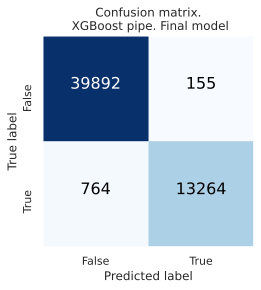

_____________________________________________________




In [49]:
get_classification_report(
                        {'XGBoost pipe': final_pipe}, \
                        X_train, y_train, X_test, y_test, \
                        classes=['False', 'True'], \
                        title='Final model'
                             )

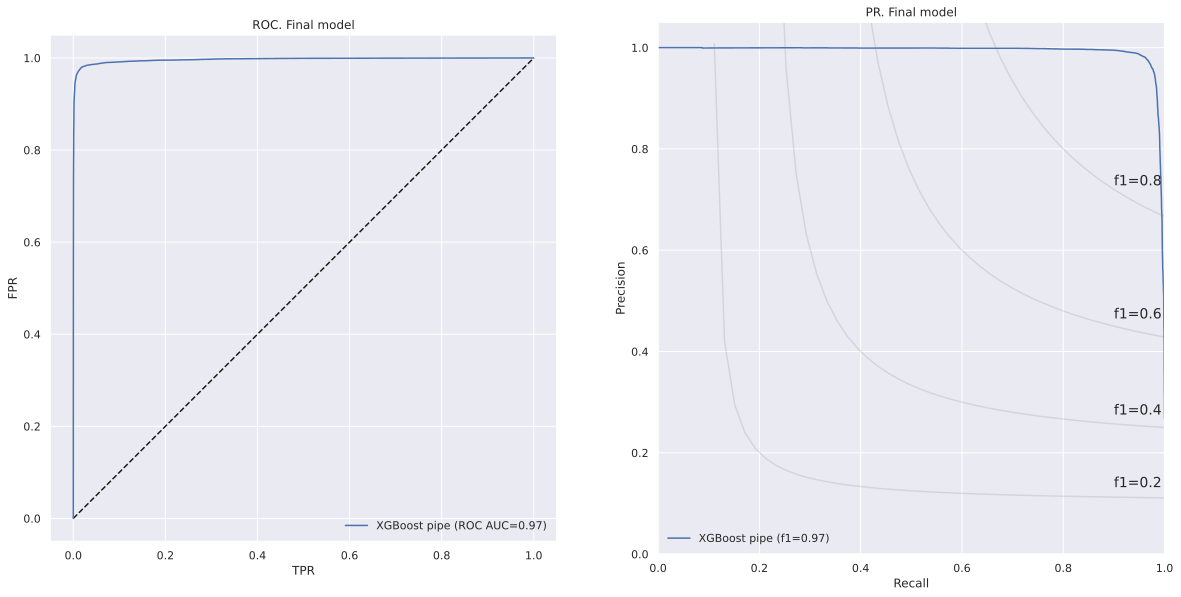

In [50]:
plot_roc_pr({'XGBoost pipe': final_pipe}, X_train, y_train, X_test, y_test, title='Final model')

### Probability calibration

In [51]:
y_test_pred_probs = final_pipe.predict_proba(X_test)

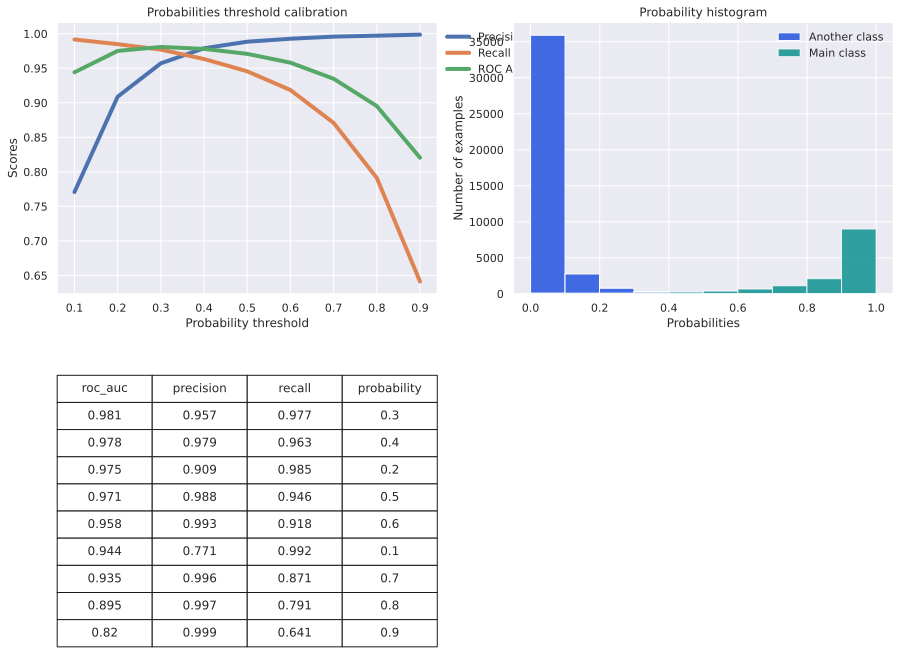

In [52]:
show_proba_calibration_plots(y_test_pred_probs[:, 1], y_test)

In [53]:
threshold = 0.3


*******XGBoost pipe. Final model with threshold******
TRAIN

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     93501
         1.0       0.99      1.00      0.99     32673

    accuracy                           1.00    126174
   macro avg       0.99      1.00      1.00    126174
weighted avg       1.00      1.00      1.00    126174

TEST

              precision    recall  f1-score   support

         0.0       0.99      0.98      0.99     40047
         1.0       0.96      0.98      0.97     14028

    accuracy                           0.98     54075
   macro avg       0.97      0.98      0.98     54075
weighted avg       0.98      0.98      0.98     54075



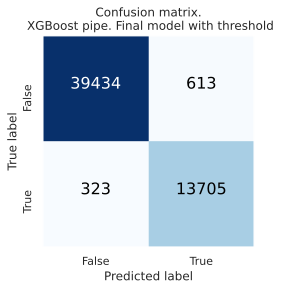

_____________________________________________________




In [54]:
get_classification_report(
                        {'XGBoost pipe': final_pipe}, \
                        X_train, y_train, X_test, y_test, \
                        classes=['False', 'True'], \
                        title='Final model with threshold',
                        threshold=threshold
                             )

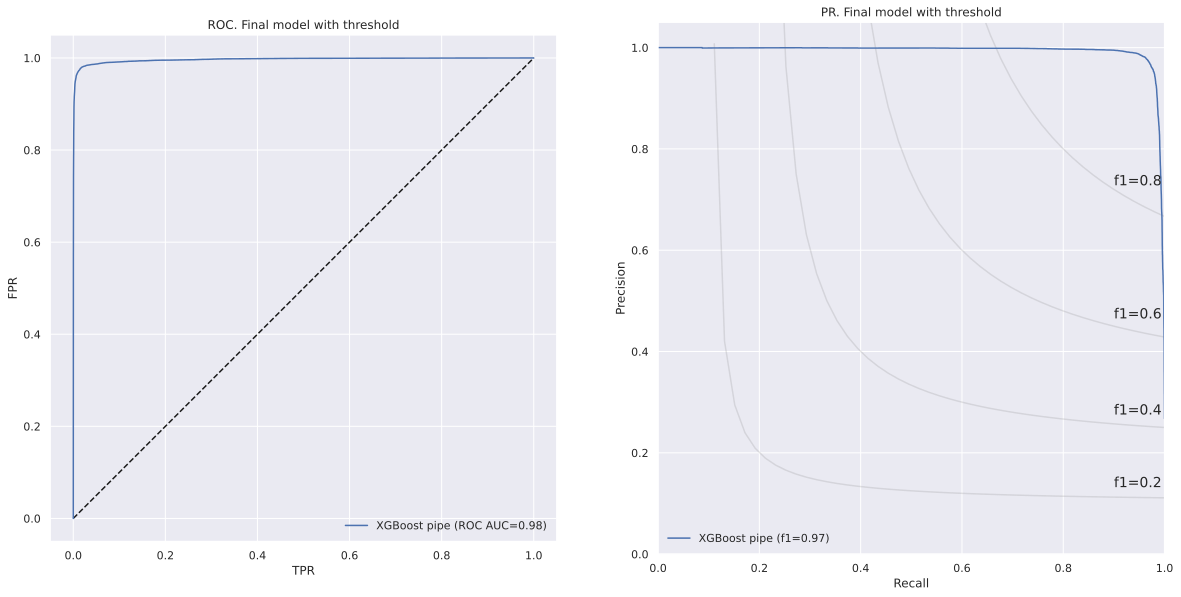

In [55]:
plot_roc_pr({'XGBoost pipe': final_pipe}, X_train, y_train, X_test, y_test, title='Final model with threshold', threshold=threshold)

## Submit
<a id=commit></a>

In [60]:
test_prepared = pd.read_csv('datasets/TEST_PREPARED.csv', index_col='email')
test_additional_data = pd.read_csv('datasets/TEST_ADDITIONAL_DATA.csv', index_col='email')
test_raw_data = pd.read_csv('datasets/TEST_RAW_DATA.csv', index_col='email')

In [61]:
test = add_features(test_prepared, additional_data=test_additional_data, raw_data=test_raw_data)

***************************************Start adding features****************************************
***************************End adding features, run time: 0:00:00.505606****************************



In [62]:
y_pred = (final_pipe.predict_proba(test)[:, 1] > threshold).astype('int')

In [63]:
submit = pd.DataFrame(y_pred, columns=[TARGET], index=test_prepared.index)

In [64]:
submit.head()

,label
email,
e98a93bfc7,0
d813ccb3f5,0
3d07a90a91,0
5791e966d8,0
d982336d49,0


In [65]:
test_prepared.shape

(10000, 144)

In [66]:
submit.shape

(10000, 1)

In [68]:
submit.to_csv('test_submit.csv')